# Imports

In [1]:
!pip install -q rectools

     |████████████████████████████████| 89 kB 2.4 MB/s 
     |████████████████████████████████| 1.1 MB 30.8 MB/s 
     |████████████████████████████████| 60 kB 4.1 MB/s 
     |████████████████████████████████| 310 kB 45.0 MB/s 
     |████████████████████████████████| 13.4 MB 35.3 MB/s 
     |████████████████████████████████| 88 kB 6.6 MB/s 
     |████████████████████████████████| 188 kB 68.3 MB/s 


In [2]:
import datetime
import numpy as np
import requests
from copy import deepcopy

from itertools import islice, cycle
from itertools import combinations
from more_itertools import pairwise
from tqdm.auto import tqdm
from scipy.stats import mode
from pprint import pprint
import pickle
import typing as tp
from zipfile import ZipFile
from scipy import sparse
from scipy.sparse import coo_matrix
from sklearn.preprocessing import normalize

import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
sns.set(style='whitegrid')
sns.set(rc={'figure.figsize':(17, 9)})

from IPython.core.display import display, HTML, clear_output
display(HTML('<style>.container { width:80% !important; }</style>'))
display(HTML('<style>.prompt { min-width:10ex !important; }</style>'))
display(HTML('<style>div#notebook { font-size:12px !important; }</style>'))

import warnings
warnings.filterwarnings("ignore")

from rectools import Columns
from rectools.dataset import Dataset, Interactions
import implicit
from lightfm import LightFM
from lightfm.data import Dataset as LFMDataset

In [4]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

# Get KION dataset 

<a href="https://ods.ai/competitions/competition-recsys-21/data"> Dataset description [ru] </a>


In [5]:
# download dataset by chunks
url = "https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip"

req = requests.get(url, stream=True)

with open('kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [6]:
import zipfile as zf

files = zf.ZipFile('kion.zip', 'r')
files.extractall()
files.close()

In [7]:
users = pd.read_csv('kion_train/users.csv')
items = pd.read_csv('kion_train/items.csv')
interactions = pd.read_csv('kion_train/interactions.csv', parse_dates=['last_watch_dt'])

# Preprocessing
Копипаст основного кода из [доступного ноутбука в сореве](https://ods.ai/competitions/competition-recsys-21/data)

## Users

In [8]:
users['age'] = users['age'].fillna('U')
users['age'] = users['age'].astype('category')

In [9]:
users['income'] = users['income'].fillna('U')
users['income'] = users['income'].astype('category')

In [10]:
users['sex'] = users['sex'].fillna('U')
users.loc[users.sex == 'М', 'sex'] = 'M'
users.loc[users.sex == 'Ж', 'sex'] = 'F'
users['sex'] = users['sex'].astype('category')

In [11]:
users['kids_flg'] = users['kids_flg'].astype('bool')

## Items

In [12]:
items['content_type'] = items['content_type'].astype('category')

In [13]:
items['title'] = items['title'].str.lower()

In [14]:
items['title_orig'] = items['title_orig'].fillna('None') 

In [15]:
items.loc[items['release_year'].isna(), 'release_year'] = 2020.

items.loc[items['release_year'] < 1920, 'release_year_cat'] = 'inf_1920'
items.loc[items['release_year'] >= 2020, 'release_year_cat'] = '2020_inf'

for i in range (1920, 2020, 10):
    items.loc[(items['release_year'] >= i) & (items['release_year'] < i+10), 'release_year_cat'] = f'{i}-{i+10}'

#items = items.drop(columns=['release_year'])
items['release_year_cat'] = items['release_year_cat'].astype('category')

In [16]:
items['genres'] = items['genres'].astype('category')

In [17]:
items.loc[items.countries.isna(), 'countries'] = 'Россия'

items['countries'] = items['countries'].str.lower()
items['countries'] = items['countries'].apply(lambda x: ', '.join(sorted(list(set(x.split(', '))))))

items['countries'] = items['countries'].astype('category')

In [18]:
items['for_kids'] = items['for_kids'].fillna(0)
items['for_kids'] = items['for_kids'].astype('bool')

In [19]:
items.loc[items.age_rating.isna(), 'age_rating'] = 0
items['age_rating'] = items['age_rating'].astype('category')

In [20]:
items['studios'] = items['studios'].fillna('Unknown')
items['studios'] = items['studios'].str.lower()
items['studios'] = items['studios'].apply(lambda x: ', '.join(sorted(list(set(x.split(', '))))))
items['studios'] = items['studios'].astype('category')

In [21]:
items['directors'] = items['directors'].fillna('Unknown')
items['directors'] = items['directors'].str.lower()
items['directors'] = items['directors'].astype('category')

In [22]:
items['actors'] = items['actors'].fillna('Unknown')
items['actors'] = items['actors'].astype('category')

In [23]:
items['keywords'] = items['keywords'].fillna('Unknown')
items['keywords'] = items['keywords'].astype('category')

In [24]:
items['description'] = items['description'].fillna('-')

## Interactions

In [25]:
interactions['watched_pct'] = interactions['watched_pct'].astype(pd.Int8Dtype())
interactions['watched_pct'] = interactions['watched_pct'].fillna(0)

In [26]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt'])

In [27]:
# rename columns, convert timestamp
interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions['datetime'] = pd.to_datetime(interactions['datetime'])

# Data check

In [28]:
def headtail(df, n=5):
    return pd.concat([df.head(n), df.tail(n)])

## interactions

In [29]:
headtail(interactions)

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72
1,699317,1659,2021-05-29,8317,100
2,656683,7107,2021-05-09,10,0
3,864613,7638,2021-07-05,14483,100
4,964868,9506,2021-04-30,6725,100
5476246,648596,12225,2021-08-13,76,0
5476247,546862,9673,2021-04-13,2308,49
5476248,697262,15297,2021-08-20,18307,63
5476249,384202,16197,2021-04-19,6203,100
5476250,319709,4436,2021-08-15,3921,45


In [30]:
print(f"Interactions dataframe shape{interactions.shape}")
print(f"Unique users in interactions: {interactions[Columns.User].nunique():_}")
print(f"Unique items in interactions: {interactions[Columns.Item].nunique():_}")

Interactions dataframe shape(5476251, 5)
Unique users in interactions: 962_179
Unique items in interactions: 15_706


In [31]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f"min date in interactions: {min_date}")
print(f"max date in interactions: {max_date}")

min date in interactions: 2021-03-13 00:00:00
max date in interactions: 2021-08-22 00:00:00


## users

In [32]:
headtail(users)

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,M,True
1,962099,age_18_24,income_20_40,M,False
2,1047345,age_45_54,income_40_60,F,False
3,721985,age_45_54,income_20_40,F,False
4,704055,age_35_44,income_60_90,F,False
840192,339025,age_65_inf,income_0_20,F,False
840193,983617,age_18_24,income_20_40,F,True
840194,251008,U,U,U,False
840195,590706,U,U,F,False
840196,166555,age_65_inf,income_20_40,F,False


In [33]:
print(f"Users dataframe shape {users.shape}")
print(f"Unique users: {users[Columns.User].nunique():_}")

Users dataframe shape (840197, 5)
Unique users: 840_197


## items

In [34]:
headtail(items, n=3)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_cat
0,10711,film,поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",испания,False,16.0,unknown,педро альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ...",2000-2010
1,2508,film,голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",сша,False,16.0,unknown,скот армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео...",2010-2020
2,10716,film,тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",канада,False,16.0,unknown,адам п. калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг...",2010-2020
15960,10632,series,сговор,Hassel,2017.0,"драмы, триллеры, криминал",россия,False,18.0,unknown,"эшреф рейбрук, амир камдин, эрик эгер","Ола Рапас, Алиетт Офейм, Уильма Лиден, Шанти Р...",Криминальная драма по мотивам романов о шведск...,"Сговор, 2017, Россия",2010-2020
15961,4538,series,среди камней,Darklands,2019.0,"драмы, спорт, криминал",россия,False,18.0,unknown,"марк о’коннор, конор макмахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия",2010-2020
15962,3206,series,гоша,None,2019.0,комедии,россия,False,16.0,unknown,михаил миронов,"Мкртыч Арзуманян, Виктория Рунцова","Добродушный Гоша не может выйти из дома, чтобы...","Гоша, 2019, Россия",2010-2020


In [35]:
print(f"Items dataframe shape {items.shape}")
print(f"Unique item_id: {items[Columns.Item].nunique():_}")

Items dataframe shape (15963, 15)
Unique item_id: 15_963


# Prepare data


In [36]:
train = interactions.loc[
    (interactions[Columns.Datetime] >= "2021-05-21")
    & (interactions[Columns.Datetime] <= "2021-08-21"),
]

test = interactions.loc[interactions[Columns.Datetime] == "2021-08-22", ["user_id", "item_id"]]
test = test.loc[test["user_id"].isin(train["user_id"]) & test["item_id"].isin(train["item_id"])]

In [37]:
train_full = pd.merge(train, items[["item_id", "title", "genres"]], on="item_id")
test_full = pd.merge(test, items[["item_id", "title", "genres"]], on="item_id")

#### Аватары

In [38]:
interactions['user_id'].max()

1097557

In [39]:
titles = [
    "джон уик", 
    "заложница", 
    "перевозчик",
    "форсаж: хоббс и шоу",
    "терминатор 3: восстание машин"
]
avatar_interactions_action = pd.DataFrame({"user_id": 10000000001, "title": titles, Columns.Datetime: "2021-05-21", "weight": 0, "watched_pct": 0})
avatar_interactions_action = avatar_interactions_action.merge(items[["item_id", "title", "genres"]], on="title")
avatar_interactions_action

,user_id,title,datetime,weight,watched_pct,item_id,genres
0,10000000001,джон уик,2021-05-21,0,0,7671,"боевики, триллеры"
1,10000000001,заложница,2021-05-21,0,0,14362,"боевики, триллеры"
2,10000000001,перевозчик,2021-05-21,0,0,8350,"боевики, триллеры, криминал"
3,10000000001,форсаж: хоббс и шоу,2021-05-21,0,0,2323,"боевики, триллеры"
4,10000000001,терминатор 3: восстание машин,2021-05-21,0,0,2925,"боевики, фантастика, триллеры"


In [40]:
titles = [
    "тупой и еще тупее 2",
    "типа крутые легавые",
    "голый пистолет",
    "убойные каникулы",
    "карты, деньги, два ствола"
]
avatar_interactions_comedy = pd.DataFrame({"user_id": 10000000002, "title": titles, Columns.Datetime: "2021-05-21", "weight": 0, "watched_pct": 0})
avatar_interactions_comedy = avatar_interactions_comedy.merge(items[["item_id", "title", "genres"]], on="title")
avatar_interactions_comedy

,user_id,title,datetime,weight,watched_pct,item_id,genres
0,10000000002,тупой и еще тупее 2,2021-05-21,0,0,8391,комедии
1,10000000002,типа крутые легавые,2021-05-21,0,0,2915,"боевики, триллеры, детективы, комедии"
2,10000000002,голый пистолет,2021-05-21,0,0,1734,комедии
3,10000000002,убойные каникулы,2021-05-21,0,0,4979,"ужасы, комедии"
4,10000000002,"карты, деньги, два ствола",2021-05-21,0,0,2866,комедии


In [41]:
train_full = pd.concat([train_full, avatar_interactions_action, avatar_interactions_comedy], sort=False)
train = train_full.drop(['title', 'genres'], axis=1)

In [42]:
train_full

,user_id,item_id,datetime,weight,watched_pct,title,genres
0,699317,1659,2021-05-29 00:00:00,8317,100,три богатыря. ход конем,"мультфильм, фэнтези, приключения, комедии"
1,637398,1659,2021-06-23 00:00:00,5907,100,три богатыря. ход конем,"мультфильм, фэнтези, приключения, комедии"
2,917784,1659,2021-08-13 00:00:00,23977,100,три богатыря. ход конем,"мультфильм, фэнтези, приключения, комедии"
3,669984,1659,2021-08-20 00:00:00,79,2,три богатыря. ход конем,"мультфильм, фэнтези, приключения, комедии"
4,325198,1659,2021-08-17 00:00:00,4460,100,три богатыря. ход конем,"мультфильм, фэнтези, приключения, комедии"
...,...,...,...,...,...,...,...
0,10000000002,8391,2021-05-21,0,0,тупой и еще тупее 2,комедии
1,10000000002,2915,2021-05-21,0,0,типа крутые легавые,"боевики, триллеры, детективы, комедии"
2,10000000002,1734,2021-05-21,0,0,голый пистолет,комедии
3,10000000002,4979,2021-05-21,0,0,убойные каникулы,"ужасы, комедии"


# 1) LightFM

In [43]:
class LFMWrapper():
    def __init__(self, learning_rate=0.01, loss='warp', no_components=64, random_state=None):
        self.model = LightFM(
            learning_rate=learning_rate, 
            loss=loss, 
            no_components=no_components,
            random_state=random_state
        )
        
    def fit(self, train, user_feature=None, epochs=20, num_threads=2):
        flatten_uf = None
        if user_feature is not None:
            user_feature = user_feature.merge(pd.Series(train["user_id"].unique(), name='user_id'), on='user_id')
            flatten_uf = user_feature.drop('user_id',axis=1).to_numpy().flatten()

        self.dataset = LFMDataset()
        self.dataset.fit(
            users=train["user_id"].values,
            items=train["item_id"].values,
            user_features=flatten_uf
        )

        self.train_matrix, _ = self.dataset.build_interactions(zip(*train[["user_id", "item_id"]].values.T))
        self.user_features_list = self.dataset.build_user_features(zip(*user_feature.values.T)) if user_feature is not None else None
        self.id_item_mapping = {v: k for k, v in self.dataset._item_id_mapping.items()}

        self.model.fit(
            interactions=self.train_matrix,
            user_features=self.user_features_list,
            epochs=epochs,
            num_threads=num_threads,
        )
        return self
    
    def recommend(self, users=None, k=10):
        users_recs = []
        for user in tqdm(users):
            user_inner_id = self.dataset._user_id_mapping[user]
            user_feats = self.user_features_list[user_inner_id] if self.user_features_list is not None else None
            scores = self.model.predict(
                user_ids=user_inner_id,
                item_ids=np.arange(self.train_matrix.shape[1]),
                user_features=self.user_features_list,
                num_threads=20
            )
            user_watched_items = self.train_matrix.col[self.train_matrix.row == user_inner_id]
            scores[user_watched_items] = -np.inf

            recommended_item_inner_ids = np.argpartition(scores, -np.arange(k))[-k:][::-1]
            recommended_item_ids = [self.id_item_mapping[x] for x in recommended_item_inner_ids]
            users_recs.extend(list(zip([user]*k, recommended_item_ids, range(1,k+1))))
        recs = pd.DataFrame(users_recs, columns=[Columns.User, Columns.Item, Columns.Rank])
        return recs

In [44]:
lfm_model = LFMWrapper()
lfm_model.fit(train, epochs=10)

In [45]:
user_id = 10000000001  # "avatar_action"

recommended_items = lfm_model.recommend([user_id])
recommended_items.merge(items[["item_id", "title", "genres"]])

  0%|          | 0/1 [00:00<?, ?it/s]

,user_id,item_id,rank,title,genres
0,10000000001,9728,1,гнев человеческий,"боевики, триллеры"
1,10000000001,13865,2,девятаев,"драмы, военные, приключения"
2,10000000001,12173,3,мстители: финал,"боевики, драмы, фантастика"
3,10000000001,7626,4,мстители: война бесконечности,"боевики, фантастика, приключения"
4,10000000001,14317,5,веном,"популярное, фантастика, триллеры, боевики, ужасы"
5,10000000001,10440,6,хрустальный,"триллеры, детективы"
6,10000000001,10942,7,мстители,"боевики, фантастика, фэнтези, приключения"
7,10000000001,3734,8,прабабушка легкого поведения,комедии
8,10000000001,5693,9,алита: боевой ангел,"боевики, фантастика, триллеры, приключения"
9,10000000001,12841,10,стражи галактики,"боевики, фантастика, приключения, комедии"


In [46]:
user_id = 10000000002  # "avatar_comedy"

recommended_items = lfm_model.recommend([user_id])
recommended_items.merge(items[["item_id", "title", "genres"]])

  0%|          | 0/1 [00:00<?, ?it/s]

,user_id,item_id,rank,title,genres
0,10000000002,9728,1,гнев человеческий,"боевики, триллеры"
1,10000000002,10440,2,хрустальный,"триллеры, детективы"
2,10000000002,13865,3,девятаев,"драмы, военные, приключения"
3,10000000002,3734,4,прабабушка легкого поведения,комедии
4,10000000002,15297,5,клиника счастья,"драмы, мелодрамы"
5,10000000002,7571,6,100% волк,"мультфильм, приключения, семейное, фэнтези, ко..."
6,10000000002,2657,7,подслушано,"драмы, триллеры"
7,10000000002,12173,8,мстители: финал,"боевики, драмы, фантастика"
8,10000000002,7626,9,мстители: война бесконечности,"боевики, фантастика, приключения"
9,10000000002,16166,10,зверополис,"приключения, мультфильм, детективы, комедии"


In [47]:
lfm_model = LFMWrapper()
lfm_model.fit(train, user_feature=users[['user_id', 'sex']], epochs=10)

In [48]:
user_id = 10000000001  # "avatar_action"

recommended_items = lfm_model.recommend([user_id])
recommended_items.merge(items[["item_id", "title", "genres"]])

  0%|          | 0/1 [00:00<?, ?it/s]

,user_id,item_id,rank,title,genres
0,10000000001,10440,1,хрустальный,"триллеры, детективы"
1,10000000001,15297,2,клиника счастья,"драмы, мелодрамы"
2,10000000001,13865,3,девятаев,"драмы, военные, приключения"
3,10000000001,9728,4,гнев человеческий,"боевики, триллеры"
4,10000000001,2657,5,подслушано,"драмы, триллеры"
5,10000000001,4151,6,секреты семейной жизни,комедии
6,10000000001,3734,7,прабабушка легкого поведения,комедии
7,10000000001,4740,8,сахаров. две жизни,документальное
8,10000000001,12192,9,фемида видит,"драмы, детективы, комедии"
9,10000000001,4880,10,афера,комедии


In [49]:
user_id = 10000000002  # "avatar_comedy"

recommended_items = lfm_model.recommend([user_id])
recommended_items.merge(items[["item_id", "title", "genres"]])

  0%|          | 0/1 [00:00<?, ?it/s]

,user_id,item_id,rank,title,genres
0,10000000002,10440,1,хрустальный,"триллеры, детективы"
1,10000000002,15297,2,клиника счастья,"драмы, мелодрамы"
2,10000000002,2657,3,подслушано,"драмы, триллеры"
3,10000000002,13865,4,девятаев,"драмы, военные, приключения"
4,10000000002,9728,5,гнев человеческий,"боевики, триллеры"
5,10000000002,4151,6,секреты семейной жизни,комедии
6,10000000002,3734,7,прабабушка легкого поведения,комедии
7,10000000002,4740,8,сахаров. две жизни,документальное
8,10000000002,4880,9,афера,комедии
9,10000000002,12192,10,фемида видит,"драмы, детективы, комедии"


# 2) Implicit


In [50]:
# Colab падает при обработке csr - видимо криво и не оптимально реализовал
class ImplicitWrapper():
    def __init__(self, factors=16, regularization=0.01, iterations=15, random_state=None):
        self.model = implicit.als.AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            iterations=iterations,
            random_state=random_state,
            use_gpu=False,
        )
        
    def fit(self, interactions):
        csr = sparse.csr_matrix(
            (
                np.ones(len(interactions)),
                (
                    interactions[Columns.User].values,
                    interactions[Columns.Item].values,
                ),
            ),
        ).T.tocsr(copy=False)
        self.model.fit(csr)
        self.user_factors = np.hstack([self.model.user_factors])
        self.item_factors = np.hstack([self.model.item_factors])
        return self
    
    def recommend(self, users, k=10):
        users_recs = []
        for user in tqdm(users):
            scores = self.item_factors @ self.user_factors[user]

            n_reco = min(k, scores.size)
            unsorted_reco_positions = scores.argpartition(-n_reco)[-n_reco:]
            unsorted_reco_scores = scores[unsorted_reco_positions]
            sorted_reco_positions = unsorted_reco_positions[unsorted_reco_scores.argsort()[::-1]]

            cur_r = list(islice(cycle(sorted_reco_positions), k))
            cur_s = list(islice(cycle(scores[sorted_reco_positions]), k))

            users_recs.extend(list(zip([user]*k, cur_r[:k], cur_s[:k])))
        recs = pd.DataFrame(users_recs, columns=[Columns.User, Columns.Item, Columns.Score])
        recs[Columns.Rank] = recs.sort_values([Columns.User, Columns.Score], ascending=False).groupby(Columns.User).cumcount() + 1
        return recs

In [51]:
from rectools.models import ImplicitALSWrapperModel

In [52]:
class ImplicitWrapper_rectools():
    def __init__(self, factors=16, regularization=0.01, iterations=15, random_state=None):
        self.model = ImplicitALSWrapperModel(
            model=implicit.als.AlternatingLeastSquares(
                factors=factors,
                regularization=regularization,
                iterations=iterations,
                random_state=random_state,
                use_gpu=False,
            )
        )
        
    def fit(self, interactions):
        self.dataset = Dataset.construct(
            interactions_df=interactions,
        )
        self.model.fit(self.dataset)
        return self
    
    def recommend(self, users, k=10, filter_viewed=True):
        return self.model.recommend(users, dataset=self.dataset, k=k, filter_viewed=filter_viewed)
        users_recs = []
        for user in tqdm(users):
            self.model.recommend([])
            cur_r = list(islice(cycle(sorted_reco_positions), k))
            cur_s = list(islice(cycle(scores[sorted_reco_positions]), k))

            users_recs.extend(list(zip([user]*k, cur_r[:k], cur_s[:k])))
        recs = pd.DataFrame(users_recs, columns=[Columns.User, Columns.Item, Columns.Score])
        recs[Columns.Rank] = recs.sort_values([Columns.User, Columns.Score], ascending=False).groupby(Columns.User).cumcount() + 1
        return recs

In [53]:
i_model = ImplicitWrapper_rectools()

In [54]:
i_model.fit(train)

In [55]:
user_id = 10000000001  # "avatar_action"

recommended_items = i_model.recommend([user_id])
recommended_items.merge(items[["item_id", "title", "genres"]])

,user_id,item_id,score,rank,title,genres
0,10000000001,13941,2.103803e-11,1,принц персии: пески времени,"боевики, фэнтези, приключения"
1,10000000001,9728,2.079276e-11,2,гнев человеческий,"боевики, триллеры"
2,10000000001,6317,2.028286e-11,3,шальная карта,"боевики, драмы, триллеры"
3,10000000001,9342,1.976074e-11,4,дэдпул,"боевики, фантастика, приключения, комедии"
4,10000000001,10440,1.944200e-11,5,хрустальный,"триллеры, детективы"
5,10000000001,4702,1.872811e-11,6,хищник,"боевики, фантастика, триллеры, приключения"
6,10000000001,1287,1.861249e-11,7,терминатор: тёмные судьбы,"боевики, фантастика, приключения"
7,10000000001,4116,1.823777e-11,8,игра эндера,"боевики, фантастика, фэнтези, приключения"
8,10000000001,734,1.819602e-11,9,бегущий по лезвию 2049,"детективы, драмы, фантастика, триллеры, боевики"
9,10000000001,10942,1.810152e-11,10,мстители,"боевики, фантастика, фэнтези, приключения"


In [56]:
user_id = 10000000002  # "avatar_comedy"

recommended_items = i_model.recommend([user_id])
recommended_items.merge(items[["item_id", "title", "genres"]])

,user_id,item_id,score,rank,title,genres
0,10000000002,4696,2.247341e-11,1,удивительное путешествие доктора дулиттла,"семейное, фэнтези, приключения, комедии"
1,10000000002,1287,2.111964e-11,2,терминатор: тёмные судьбы,"боевики, фантастика, приключения"
2,10000000002,2852,2.090013e-11,3,сквозь снег,"боевики, драмы, фантастика"
3,10000000002,10440,2.086271e-11,4,хрустальный,"триллеры, детективы"
4,10000000002,4740,2.022952e-11,5,сахаров. две жизни,документальное
5,10000000002,10811,1.967016e-11,6,отель мумбаи: противостояние,"боевики, драмы, историческое, триллеры"
6,10000000002,9728,1.950261e-11,7,гнев человеческий,"боевики, триллеры"
7,10000000002,13941,1.856226e-11,8,принц персии: пески времени,"боевики, фэнтези, приключения"
8,10000000002,5087,1.761110e-11,9,великий уравнитель 2,"боевики, триллеры, криминал"
9,10000000002,4702,1.742573e-11,10,хищник,"боевики, фантастика, триллеры, приключения"


# Validation

In [57]:
from rectools.model_selection import TimeRangeSplitter
from rectools.metrics import MAP, Recall, calc_metrics

In [58]:
n_folds = 3
unit = "D"
n_units = 7
# last_date = interactions[Columns.Datetime].max().normalize()
last_date = pd.to_datetime('15-08-2021', format='%d-%m-%Y')


start_date = last_date - pd.Timedelta(n_folds * n_units - 1, unit=unit)
periods = n_folds + 1
freq = f"{n_units}{unit}"
print(f"""
    start_date: {start_date}
    last_date: {last_date}
    periods: {periods}
    freq: {freq}
""")

date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)
date_range


    start_date: 2021-07-26 00:00:00
    last_date: 2021-08-15 00:00:00
    periods: 4
    freq: 7D



DatetimeIndex(['2021-07-26', '2021-08-02', '2021-08-09', '2021-08-16'], dtype='datetime64[ns]', freq='7D')

In [59]:
inters = Interactions(interactions)

In [60]:
inters.df

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250.0,72
1,699317,1659,2021-05-29,8317.0,100
2,656683,7107,2021-05-09,10.0,0
3,864613,7638,2021-07-05,14483.0,100
4,964868,9506,2021-04-30,6725.0,100
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76.0,0
5476247,546862,9673,2021-04-13,2308.0,49
5476248,697262,15297,2021-08-20,18307.0,63
5476249,384202,16197,2021-04-19,6203.0,100


In [61]:
cv = TimeRangeSplitter(
    date_range=date_range,
    filter_already_seen=True,
)

In [62]:
fold_iterator = cv.split(inters, collect_fold_stats=True)

for i_fold, (train_ids, test_ids, fold_info) in enumerate(fold_iterator):
    print(f"\n==================== Fold {i_fold}")
    pprint(fold_info)
    
    df_train = inters.df.iloc[train_ids]
    df_test = inters.df.iloc[test_ids][Columns.UserItem]
    print(f'Train: {df_train.shape[0]} | Test:{df_test.shape[0]}')


==================== Fold 0
{'End date': Timestamp('2021-08-02 00:00:00', freq='7D'),
 'Start date': Timestamp('2021-07-26 00:00:00', freq='7D'),
 'Test': 254565,
 'Test items': 6650,
 'Test users': 94910,
 'Train': 3892558,
 'Train items': 15085,
 'Train users': 742256}
Train: 3892558 | Test:254565

==================== Fold 1
{'End date': Timestamp('2021-08-09 00:00:00', freq='7D'),
 'Start date': Timestamp('2021-08-02 00:00:00', freq='7D'),
 'Test': 263681,
 'Test items': 6602,
 'Test users': 98184,
 'Train': 4266013,
 'Train items': 15237,
 'Train users': 797423}
Train: 4266013 | Test:263681

==================== Fold 2
{'End date': Timestamp('2021-08-16 00:00:00', freq='7D'),
 'Start date': Timestamp('2021-08-09 00:00:00', freq='7D'),
 'Test': 279422,
 'Test items': 6698,
 'Test users': 103511,
 'Train': 4649162,
 'Train items': 15415,
 'Train users': 850489}
Train: 4649162 | Test:279422


Time for models and metrics

In [69]:
RS = 42

lfm_models = {
    'lfm_01_warp_10': LFMWrapper(learning_rate=0.01, loss='warp', no_components=10, random_state=RS),
    'lfm_001_warp_64': LFMWrapper(learning_rate=0.001, loss='logistic', no_components=64, random_state=RS),
}

i_models = {
    'i_16_01_15': ImplicitWrapper_rectools(factors=16, regularization=0.01, iterations=15, random_state=RS),
    'i_16_001_30': ImplicitWrapper_rectools(factors=16, regularization=0.001, iterations=30, random_state=RS),
}

K_RECOS = 10
metrics = {
    "Recall@10": Recall(k=10),
    "MAP@10": MAP(k=10),
}

In [70]:
fold_iterator = cv.split(inters)
results = []

pbar = tqdm(enumerate(fold_iterator), total=cv.get_n_splits(inters))

for i_fold, (train_ids, test_ids, _) in pbar:     
    pbar.set_description(f'Fold#{i_fold}')
    
    df_train = inters.df.iloc[train_ids]
    
    df_test = inters.df.iloc[test_ids][Columns.UserItem]
    test_users = np.intersect1d(np.unique(df_test[Columns.User]), np.unique(df_train[Columns.User]))

    for model_name, model in lfm_models.items():
        model = deepcopy(model)
        model.fit(df_train, users[['user_id', 'sex']], epochs=1)
        recos = model.recommend(
            users=test_users,
            k=K_RECOS,
        )
        metric_values = calc_metrics(
            metrics,
            reco=recos,
            interactions=df_test,
            prev_interactions=df_train
        )
        res = {"fold": i_fold, "model": model_name}
        res.update(metric_values)
        results.append(res)
      
    for model_name, model in i_models.items():
        model = deepcopy(model)
        model.fit(df_train)
        recos = model.recommend(
            users=test_users,
            k=K_RECOS,
            filter_viewed=True,
        )
        metric_values = calc_metrics(
            metrics,
            reco=recos,
            interactions=df_test,
            prev_interactions=df_train
        )
        res = {"fold": i_fold, "model": model_name}
        res.update(metric_values)
        results.append(res)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/94910 [00:00<?, ?it/s]

  0%|          | 0/94910 [00:00<?, ?it/s]

  0%|          | 0/98184 [00:00<?, ?it/s]

  0%|          | 0/98184 [00:00<?, ?it/s]

  0%|          | 0/103511 [00:00<?, ?it/s]

  0%|          | 0/103511 [00:00<?, ?it/s]

In [71]:
df_results = pd.DataFrame(results)
df_results

,fold,model,Recall@10,MAP@10
0,0,lfm_01_warp_10,0.190387,0.090883
1,0,lfm_001_warp_64,0.190236,0.091321
2,0,i_16_01_15,0.052389,0.021869
3,0,i_16_001_30,0.067630,0.030329
4,1,lfm_01_warp_10,0.182558,0.090420
5,1,lfm_001_warp_64,0.183137,0.089885
6,1,i_16_01_15,0.051178,0.019014
7,1,i_16_001_30,0.066715,0.026088
8,2,lfm_01_warp_10,0.174467,0.083980
9,2,lfm_001_warp_64,0.170748,0.083637


In [72]:
# Aggregate metrics by folds and compare models
pivot_results = pd.DataFrame(results).drop(columns='fold').groupby(['model'], sort=False).agg(['mean', 'std'])
pivot_results.round(5)

Recall@10            MAP@10         
                     mean      std     mean      std
model                                               
lfm_01_warp_10    0.18247  0.00796  0.08843  0.00386
lfm_001_warp_64   0.18137  0.00986  0.08828  0.00409
i_16_01_15        0.05362  0.00323  0.02115  0.00188
i_16_001_30       0.06909  0.00336  0.02848  0.00217

In [73]:
pivot_results.round(5).sort_values(by=[('MAP@10', 'mean'), ('Recall@10', 'mean')], ascending=False)

Recall@10            MAP@10         
                     mean      std     mean      std
model                                               
lfm_01_warp_10    0.18247  0.00796  0.08843  0.00386
lfm_001_warp_64   0.18137  0.00986  0.08828  0.00409
i_16_001_30       0.06909  0.00336  0.02848  0.00217
i_16_01_15        0.05362  0.00323  0.02115  0.00188

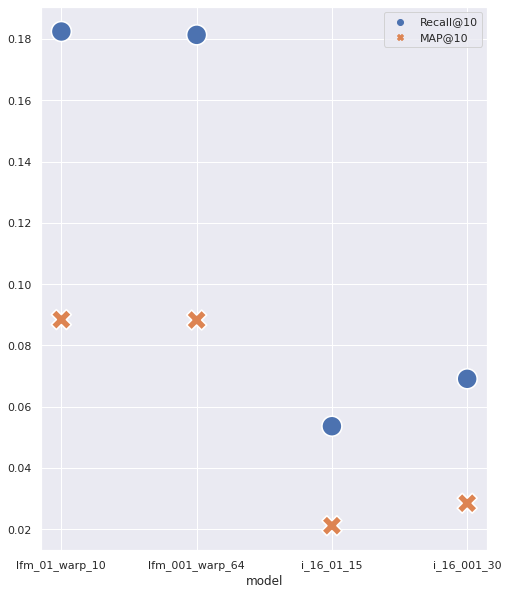

In [74]:
plt.figure(figsize=(8, 10))
sns.scatterplot(data=pd.DataFrame(results).drop(columns='fold').groupby(['model'], sort=False).mean(), s=400)

Качество у LightFM модели лучше, чем у implicit с подобранными гиперпараметрами

# Submission
Зашлем первые 3 модели (интересно как поведет себяя худшая модель), но для холодных возьмем лучшую модель из 1 дз

In [79]:
submission = pd.read_csv('sample_submission.csv')
train = interactions
test = submission
top_K=10

In [95]:
class MyPopularInUserCategoryModel():
    def __init__(self, category_feature: str, period: pd.Timedelta = None):
        self.cat_feat = category_feature
        self.period = period
        
    def fit(self, interactions, users_data, nan_value):
        self.users_data = users_data
        self.nan_val = nan_value
        self.data = interactions.merge(
            users_data[[Columns.User, self.cat_feat]],
            how='left',
            on=Columns.User,
        )
        
        if nan_value:
          self.data = self.data.fillna(value={self.cat_feat: nan_value})
        
        if self.period is not None:
            dt = interactions[Columns.Datetime]
            min_date = dt.max().normalize() - self.period
            interactions = interactions[dt > min_date]
        
        self.sorted_items = {}
        for cur_cat in users_data[self.cat_feat].unique():
            self.sorted_items[cur_cat] = self.data[self.data[self.cat_feat] == cur_cat] \
                .groupby(Columns.Item)[Columns.User] \
                .nunique().sort_values(ascending=False)
        return self
    
    def recommend(self, users, k=10, filter_viewed=False):
        users_recs = []
        for user in users:
            if (self.users_data[Columns.User]==user).any():
                cur_cat = self.users_data[self.users_data[Columns.User]==user][self.cat_feat].values[0]
            else:
                cur_cat = self.nan_val
            viewed = [None]
            if filter_viewed:
                viewed = self.data[self.data[Columns.User]==user][Columns.Item].values
            not_viewed_top = self.sorted_items[cur_cat][~(self.sorted_items[cur_cat].index.isin(viewed))]
            users_recs.extend(list(zip([user]*k, not_viewed_top.index.values[:k], not_viewed_top.values[:k])))
        recs = pd.DataFrame(users_recs, columns=[Columns.User, Columns.Item, Columns.Score])
        recs[Columns.Rank] = recs.sort_values([Columns.User, Columns.Score], ascending=False).groupby(Columns.User).cumcount() + 1
        return recs

pop_model_catu = MyPopularInUserCategoryModel(category_feature='sex',)
pop_model_catu.fit(train, users, nan_value='U')
recs_popcatu = pop_model_catu.recommend(test['user_id'].unique(), k=top_K).groupby('user_id')['item_id'].apply(list).reset_index()
recs_popcatu.head()

,user_id,item_id
0,3,"[10440, 15297, 2657, 4151, 13865, 9728, 3734, ..."
1,11,"[9728, 10440, 13865, 15297, 3734, 4151, 4880, ..."
2,29,"[10440, 15297, 2657, 4151, 13865, 9728, 3734, ..."
3,30,"[10440, 15297, 2657, 4151, 13865, 9728, 3734, ..."
4,33,"[10440, 15297, 2657, 4151, 13865, 9728, 3734, ..."


In [89]:
lfm_01_warp_10 = LFMWrapper(learning_rate=0.01, loss='warp', no_components=10, random_state=RS)
lfm_01_warp_10.fit(train)
test_users = np.intersect1d(np.unique(test[Columns.User]), np.unique(train[Columns.User]))
recs_lfm_01_warp_10 = lfm_01_warp_10.recommend(test_users, k=top_K).groupby('user_id')['item_id'].apply(list).reset_index()
recs_lfm_01_warp_10.head()

  0%|          | 0/128170 [00:00<?, ?it/s]

,user_id,item_id
0,3,"[13865, 15297, 7571, 7829, 14431, 8636, 4457, ..."
1,11,"[10440, 9728, 13865, 4151, 3734, 2657, 4880, 1..."
2,30,"[10440, 13865, 15297, 3734, 4151, 12173, 7626,..."
3,39,"[10440, 13865, 9728, 4151, 2657, 3734, 4880, 1..."
4,46,"[9728, 13865, 15297, 4151, 3734, 2657, 9996, 1..."


In [98]:
recs_lfm_01_warp_10.to_csv('lfm_01_warp_10_sub.csv', index=False)

In [106]:
recs_lfm_01_warp_10_wpop = recs_popcatu.copy(deep=True)
recs_lfm_01_warp_10_wpop['item_id'] = recs_lfm_01_warp_10['item_id'].combine_first(recs_popcatu['item_id'])
recs_lfm_01_warp_10_wpop.to_csv('lfm_01_warp_10_wpop_sub.csv', index=False)
recs_lfm_01_warp_10_wpop.head()

,user_id,item_id
0,3,"[13865, 15297, 7571, 7829, 14431, 8636, 4457, ..."
1,11,"[10440, 9728, 13865, 4151, 3734, 2657, 4880, 1..."
2,29,"[10440, 13865, 15297, 3734, 4151, 12173, 7626,..."
3,30,"[10440, 13865, 9728, 4151, 2657, 3734, 4880, 1..."
4,33,"[9728, 13865, 15297, 4151, 3734, 2657, 9996, 1..."


Получили скор 0,0802666931

In [ ]:
lfm_001_warp_64 = LFMWrapper(learning_rate=0.001, loss='logistic', no_components=64, random_state=RS)
lfm_001_warp_64.fit(train)
test_users = np.intersect1d(np.unique(test[Columns.User]), np.unique(train[Columns.User]))
recs_lfm_001_warp_64 = lfm_001_warp_64.recommend(test_users, k=top_K).groupby('user_id')['item_id'].apply(list).reset_index()

In [92]:
recs_lfm_001_warp_64.head()

,user_id,item_id
0,3,"[15297, 13865, 6809, 9996, 8636, 4740, 7571, 1..."
1,11,"[10440, 9728, 13865, 4151, 3734, 2657, 4880, 1..."
2,30,"[10440, 15297, 13865, 4151, 3734, 2657, 4880, ..."
3,39,"[10440, 9728, 13865, 4151, 3734, 2657, 4880, 1..."
4,46,"[15297, 9728, 13865, 4151, 3734, 2657, 6809, 1..."


In [99]:
recs_lfm_001_warp_64.to_csv('lfm_001_warp_64_sub.csv', index=False)

In [107]:
recs_lfm_001_warp_64_wpop = recs_popcatu.copy(deep=True)
recs_lfm_001_warp_64_wpop['item_id'] = recs_lfm_001_warp_64['item_id'].combine_first(recs_popcatu['item_id'])
recs_lfm_001_warp_64_wpop.to_csv('lfm_001_warp_64_wpop_sub.csv', index=False)
recs_lfm_001_warp_64_wpop.head()

,user_id,item_id
0,3,"[15297, 13865, 6809, 9996, 8636, 4740, 7571, 1..."
1,11,"[10440, 9728, 13865, 4151, 3734, 2657, 4880, 1..."
2,29,"[10440, 15297, 13865, 4151, 3734, 2657, 4880, ..."
3,30,"[10440, 9728, 13865, 4151, 3734, 2657, 4880, 1..."
4,33,"[15297, 9728, 13865, 4151, 3734, 2657, 6809, 1..."


Получили скор 0,0837025524	

In [97]:
i_16_01_15 = ImplicitWrapper_rectools(factors=16, regularization=0.001, iterations=30, random_state=RS)
i_16_01_15.fit(train)
test_users = np.intersect1d(np.unique(test[Columns.User]), np.unique(train[Columns.User]))
recs_i_16_01_15 = i_16_01_15.recommend(test_users, k=top_K,filter_viewed=True).groupby('user_id')['item_id'].apply(list).reset_index()
recs_i_16_01_15.head()

,user_id,item_id
0,3,"[11697, 3017, 657, 16064, 6646, 4718, 6033, 10..."
1,11,"[4685, 456, 14317, 1844, 13058, 9728, 15531, 1..."
2,30,"[849, 10821, 12048, 5838, 7424, 6691, 13007, 1..."
3,39,"[9728, 341, 142, 12192, 7571, 5732, 1916, 3076..."
4,46,"[849, 13598, 3402, 10281, 9348, 4151, 6948, 13..."


In [100]:
recs_i_16_01_15.to_csv('i_16_01_15_sub.csv', index=False)

In [108]:
recs_i_16_01_15_wpop = recs_popcatu.copy(deep=True)
recs_i_16_01_15_wpop['item_id'] = recs_i_16_01_15['item_id'].combine_first(recs_popcatu['item_id'])
recs_i_16_01_15_wpop.to_csv('i_16_01_15_wpop_sub.csv', index=False)
recs_i_16_01_15_wpop.head()

,user_id,item_id
0,3,"[11697, 3017, 657, 16064, 6646, 4718, 6033, 10..."
1,11,"[4685, 456, 14317, 1844, 13058, 9728, 15531, 1..."
2,29,"[849, 10821, 12048, 5838, 7424, 6691, 13007, 1..."
3,30,"[9728, 341, 142, 12192, 7571, 5732, 1916, 3076..."
4,33,"[849, 13598, 3402, 10281, 9348, 4151, 6948, 13..."


Получили скор 0,0449521136

In [111]:
res_pd = pd.DataFrame(results).drop(columns='fold').groupby(['model'], sort=False).mean()
res_pd['MAP@10_pub'] = [0.0802666931, 0.0837025524, 0.0449521136, None]
res_pd

,Recall@10,MAP@10,MAP@10_pub
model,,,
lfm_01_warp_10,0.182471,0.088428,0.080267
lfm_001_warp_64,0.181373,0.088281,0.083703
i_16_01_15,0.053615,0.021147,0.044952
i_16_001_30,0.069094,0.028478,NaN


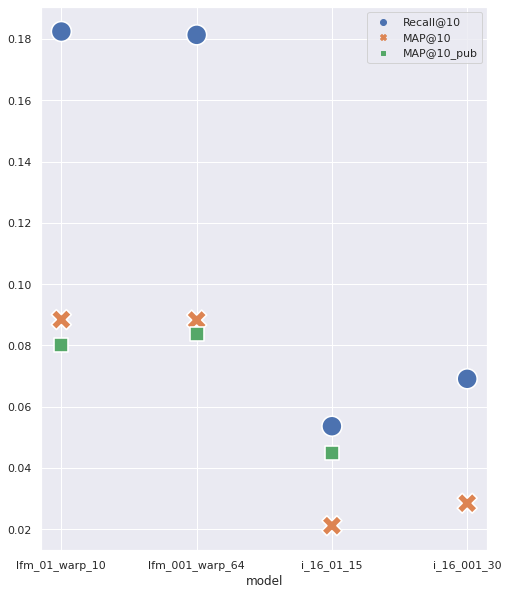

In [112]:
plt.figure(figsize=(8, 10))
sns.scatterplot(data=res_pd, s=400)

## Вывод
Получили на лидерборде сильно хуже для lightfm и чуть хуже для implicit.
Причем метрики вышли даже хуже, чем для моделей из 1 дз.